# Import Requirements

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

# Import Data

<p>I downloaded the StackSample dataset from Kaggle. This dataset includes text data from 10% of the Questions and Answers on programming topics found on Stack Overflow. The data set consists of 3 csv files:</p>
<ul>
<li>Questions.csv</li>
<li>Answers.csv</li>
<li>Tags.csv</li>
</ul>

In [2]:
questions_df = pd.read_csv('Questions.csv')
questions_df.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [3]:
answers_df = pd.read_csv('Answers.csv')
answers_df.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,92,61.0,2008-08-01T14:45:37Z,90,13,"<p><a href=""http://svnbook.red-bean.com/"">Vers..."
1,124,26.0,2008-08-01T16:09:47Z,80,12,<p>I wound up using this. It is a kind of a ha...
2,199,50.0,2008-08-01T19:36:46Z,180,1,<p>I've read somewhere the human eye can't dis...
3,269,91.0,2008-08-01T23:49:57Z,260,4,"<p>Yes, I thought about that, but I soon figur..."
4,307,49.0,2008-08-02T01:49:46Z,260,28,"<p><a href=""http://www.codeproject.com/Article..."


# Survey Data

In [4]:
print 'Total Questions:', questions_df.shape[0]
print 'Total Answers:', answers_df.shape[0]

Total Questions: 1264216
Total Answers: 2014516


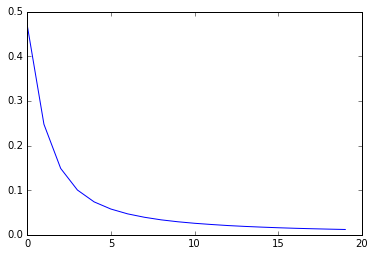

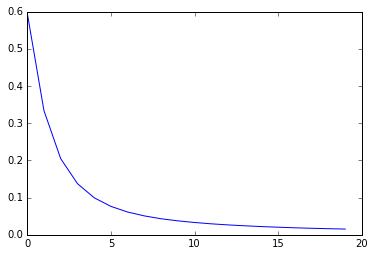

In [5]:
def calc_percentage_over_score(S, score):
    tot = len(S)
    p = []
    for i in range(score):
        S = [s for s in S if s>i]
        p.append(round(len(S)/tot,4))
    return p

p_questions = calc_percentage_over_score(questions_df.Score, 20)
p_answers = calc_percentage_over_score(answers_df.Score, 20)

# plot which percentage of questions have a score above a certain threshold (x)
plt.plot(p_questions)
plt.show()

# plot which percentage of answers have a score above a certain threshold (x)
plt.plot(p_answers)
plt.show()

# Pre-process Data

In [23]:
# remove questions with < 5 points
q_mask = questions_df.Score >= 5
q_df = questions_df[q_mask]
print q_df.shape[0]

93153


# Merge Dataframes

In [18]:
# Inner join - removes any questions without an answer
m_df = pd.merge(q_df, answers_df, how='inner', left_on='Id', right_on='ParentId')
print m_df.shape
m_df.head(1)

(312888, 13)


,Id_x,OwnerUserId_x,CreationDate_x,ClosedDate,Score_x,Title,Body_x,Id_y,OwnerUserId_y,CreationDate_y,ParentId,Score_y,Body_y
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,124,26.0,2008-08-01T16:09:47Z,80,12,<p>I wound up using this. It is a kind of a ha...


In [30]:
c = Counter(m_df.Title)
print len([i for i in c.items() if i[1] >= 5]), 'potential documents (questions with at least 5 answers)'

20658 potential documents (questions with at least 5 answers)


# Create new Dataframe containing all documents

In [138]:
def group_to_document(group):
    doc_items = []
    # extract title, question, and answers from the group
    # double check on unicode encoding/decoding
    doc_title = [list(group.Title)[0].decode('utf-8')]
    doc_q = [list(group.Body_x)[0].decode('utf-8')]
    doc_answers = [a.decode('utf-8') for a in list(group.Body_y)]
    # add the title, question, and answers to a list
    doc_items.extend(doc_title)
    doc_items.extend(doc_q)
    doc_items.extend(doc_answers)
    # join all elements in the list into one large string
    doc = ' '.join(doc_items)
    return doc

def get_documents_dataframe(m_df, num_answers):
    document_dict = {'Index':[], 'Document':[]}
    for title, group in m_df.groupby('Title'):
        if group.shape[0] >= num_answers:
            document_dict['Index'].append(int(list(group.Id_x)[0]))
            document_dict['Document'].append(group_to_document(group))
    documents_df = pd.DataFrame(document_dict)
    return documents_df

In [139]:
documents_df = get_documents_dataframe(m_df, 5)
print documents_df.shape
documents_df.head()

(20658, 2)


,Document,Index
0,How to use custom font with WebView <p>Now I ...,1344080
1,‘Remember Me’ Login in CodeIgniter <p>How do ...,419900
2,! operator in JavaScript <p>I am now confused ...,10710770
3,! vs == nil in objective-c <p>If you have an o...,6782190
4,"""#include"" a text file in a C program as a cha...",410980


# Evaluate Document Lengths

6566.18602963
5418.53374973


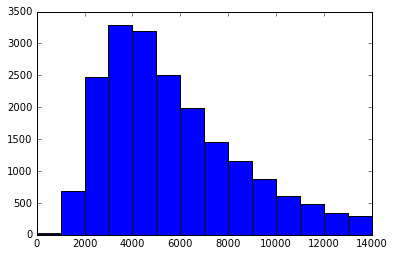

In [152]:
doc_lengths = [len(a) for a in list(documents_df.Document)]

print np.mean(doc_lengths)
print np.std(doc_lengths)

plt.hist(doc_lengths, bins=range(0,15000,1000))
plt.show()

# Next Steps

In [ ]:
# 1. clean up the documents more (remove html tags mainly)
# 2. begin NLP, probably in a separate notebook/workflow

In [ ]:
# This data set could be qualitatively compared to the "tags" for each question
# Are user-generated tags better than LDA topics?
# Can compare this dataset to R/Python Questions and compare